In [1]:
# ============================================
# Cell 0: Imports, config, and scoring dict
# ============================================

import os
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
)

import matplotlib.pyplot as plt

# If xgboost is not installed, uncomment:
# !pip install xgboost

from xgboost import XGBClassifier

# Paths (adjust if needed)
POS_FASTA = "Positive_Final.fasta"   # positive = RBP
NEG_FASTA = "Negative_Final.fasta"   # negative = non-RBP

# Amino acid definitions (fixed order)
AA_ORDER = list("ACDEFGHIKLMNPQRSTVWY")
AA_INDEX = {aa: i for i, aa in enumerate(AA_ORDER)}

RANDOM_STATE = 42

# Scoring metrics for cross-validation
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}


In [2]:
# =========================
# Cell 1: FASTA → DataFrame
# =========================

def read_fasta(path):
    """
    Minimal FASTA reader.
    Returns dict: {sequence_id: sequence_string}
    """
    seqs = {}
    header = None
    parts = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header is not None:
                    seqs[header] = "".join(parts).replace(" ", "").upper()
                header = line[1:].split()[0]   # take first token after '>'
                parts = []
            else:
                parts.append(line)
    if header is not None:
        seqs[header] = "".join(parts).replace(" ", "").upper()
    return seqs


# Load your dataset
pos_seqs = read_fasta(POS_FASTA)
neg_seqs = read_fasta(NEG_FASTA)

print(f"Loaded {len(pos_seqs)} positive (RBP) sequences")
print(f"Loaded {len(neg_seqs)} negative (non-RBP) sequences")

def build_labeled_df(pos_dict, neg_dict):
    rows = []
    for sid, seq in pos_dict.items():
        rows.append({"id": sid, "sequence": seq, "label": 1})
    for sid, seq in neg_dict.items():
        rows.append({"id": sid, "sequence": seq, "label": 0})
    return pd.DataFrame(rows)

df = build_labeled_df(pos_seqs, neg_seqs)

print(df.head())
print("\nLabel counts:")
print(df["label"].value_counts())
print("\nSequence length stats:")
print(df["sequence"].str.len().describe())


Loaded 3741 positive (RBP) sequences
Loaded 3712 negative (non-RBP) sequences
                          id  \
0  sp|A0A0A7HFE1|CAS10_STRTR   
1  sp|A0A0A7HIX6|CSM6A_STRTR   
2   sp|A0A0B4KGY6|NOVA_DROME   
3   sp|A0A0D1DWZ5|RRM4_MYCMD   
4  sp|A0A0F6B5X4|TACT3_SALT1   

                                            sequence  label  
0  MKKEKIDLFYGALLHDIGKVIQRATGERKKHALVGADWFDEIADNQ...      1  
1  MKILISAVGTTDPISNNHDAALLHIARNYRPDKIVLVYSQEMMVKQ...      1  
2  MESIMKVAMDKAAEQLIQQFGFDYLQQQLQLQHQNQHNSSPQQPQH...      1  
3  MSDSIYAPHNKHKLEAARAADAAADDAATVSALVEPTDSTAQASHA...      1  
4  MMFTDWHEAAIGKTHNRMNFDCGDADLNQFLQRHARQNHEKGTTKT...      1  

Label counts:
label
1    3741
0    3712
Name: count, dtype: int64

Sequence length stats:
count    7453.000000
mean      464.597478
std       441.237939
min        50.000000
25%       197.000000
50%       352.000000
75%       579.000000
max      5628.000000
Name: sequence, dtype: float64


In [3]:
# =========================
# Cell 2: AAC features
# =========================

def compute_aac(seq, aa_order=AA_ORDER):
    """
    Amino Acid Composition (AAC):
    p_i = l_i / L, where l_i is count of AA i and L is sequence length.
    Returns a len(aa_order)-dim numpy array.
    """
    counts = np.zeros(len(aa_order), dtype=float)
    L = 0
    for aa in seq:
        if aa in AA_INDEX:
            counts[AA_INDEX[aa]] += 1
            L += 1
    if L > 0:
        counts /= L
    return counts


# Quick sanity check
test_aac = compute_aac(df["sequence"].iloc[0])
print("AAC length:", len(test_aac))
print("AAC sum:", test_aac.sum())


AAC length: 20
AAC sum: 1.0


In [4]:
# =========================
# Cell 3: Dipeptide features
# =========================

# All possible dipeptides in fixed order: AA, AC, AD, ..., YY
DIPEPTIDES = [a + b for a in AA_ORDER for b in AA_ORDER]
DIPEP_INDEX = {dp: i for i, dp in enumerate(DIPEPTIDES)}

def compute_dipeptide_composition(seq):
    """
    Dipeptide composition:
    frequency of each possible pair (AA, AC, ..., YY) normalized by (L-1).
    Returns a 400-dim vector in DIPEPTIDES order.
    """
    L = len(seq)
    counts = np.zeros(len(DIPEPTIDES), dtype=float)
    if L < 2:
        return counts  # no dipeptides possible

    total = 0
    for i in range(L - 1):
        a1, a2 = seq[i], seq[i+1]
        if a1 in AA_INDEX and a2 in AA_INDEX:
            dp = a1 + a2
            idx = DIPEP_INDEX[dp]
            counts[idx] += 1
            total += 1

    if total > 0:
        counts /= total
    return counts


# Sanity check
test_dipep = compute_dipeptide_composition(df["sequence"].iloc[0])
print("Dipeptide vector length:", len(test_dipep))
print("Dipeptide sum:", test_dipep.sum())


Dipeptide vector length: 400
Dipeptide sum: 1.0


In [5]:
# =========================
# Cell 4: Feature extraction
# =========================

def extract_features(df):
    """
    Build feature matrix X and label vector y using:
      - AAC (20)
      - Dipeptide composition (400)
      - Sequence length (1)
    Total: 421 features.
    """
    X_list = []
    y_list = []
    ids = []

    for _, row in df.iterrows():
        seq_id = row["id"]
        seq = row["sequence"]
        label = row["label"]

        aac    = compute_aac(seq)                     # 20
        dipep  = compute_dipeptide_composition(seq)   # 400
        length = np.array([len(seq)], dtype=float)    # 1

        feats = np.concatenate([aac, dipep, length])
        X_list.append(feats)
        y_list.append(label)
        ids.append(seq_id)

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=int)
    ids = np.array(ids)
    return X, y, ids

X, y, ids = extract_features(df)
print("Feature matrix shape:", X.shape)  # (N_samples, 421)


Feature matrix shape: (7453, 421)


In [6]:
# ======================================
# Cell 5: Train-test split (shared for RF & XGB)
# ======================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 5962
Test size : 1491


In [7]:
# ======================================
# Cell 6: Baseline model - Random Forest
# ======================================

rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest (test set) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"MCC:       {matthews_corrcoef(y_test, y_pred_rf):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_proba_rf):.4f}")


=== Random Forest (test set) ===
Accuracy:  0.7136
Precision: 0.7082
Recall:    0.7299
F1-score:  0.7189
MCC:       0.4274
AUC:       0.8016


In [8]:
# ======================================
# Cell 7: 5-fold CV for Random Forest
# ======================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf_for_cv = RandomForestClassifier(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_results_rf = cross_validate(
    rf_for_cv,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
)

print("=== 5-fold CV (Random Forest) ===")
for metric, values in cv_results_rf.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:10s}: mean={values.mean():.4f}, std={values.std():.4f}")


=== 5-fold CV (Random Forest) ===
accuracy  : mean=0.7323, std=0.0109
precision : mean=0.7279, std=0.0126
recall    : mean=0.7458, std=0.0152
f1        : mean=0.7366, std=0.0108
roc_auc   : mean=0.8143, std=0.0111


In [9]:
# ======================================
# Cell 8: Final model - XGBoost (best)
# ======================================

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost (test set) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"MCC:       {matthews_corrcoef(y_test, y_pred_xgb):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_proba_xgb):.4f}")


=== XGBoost (test set) ===
Accuracy:  0.7438
Precision: 0.7346
Recall:    0.7660
F1-score:  0.7500
MCC:       0.4880
AUC:       0.8273


In [10]:
# ======================================
# Cell 9: 5-fold CV for XGBoost
# ======================================

xgb_for_cv = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_results_xgb = cross_validate(
    xgb_for_cv,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
)

print("=== 5-fold CV (XGBoost) ===")
for metric, values in cv_results_xgb.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:10s}: mean={values.mean():.4f}, std={values.std():.4f}")


=== 5-fold CV (XGBoost) ===
accuracy  : mean=0.7524, std=0.0039
precision : mean=0.7455, std=0.0074
recall    : mean=0.7699, std=0.0091
f1        : mean=0.7574, std=0.0035
roc_auc   : mean=0.8347, std=0.0084


In [11]:
# ======================================
# Cell 10: Feature importance (Random Forest)
# ======================================

# Build feature names: 20 AAC, 400 dipeptides, 1 length
aac_names = [f"AAC_{aa}" for aa in AA_ORDER]
dipep_names = [f"DIPEP_{dp}" for dp in DIPEPTIDES]
feat_names = aac_names + dipep_names + ["SEQ_LEN"]

importances_rf = rf.feature_importances_
imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances_rf
}).sort_values("importance", ascending=False)

print("Top 20 most important features (RF):")
print(imp_df.head(20))

# Save to CSV if you want to inspect later
imp_df.to_csv("rf_feature_importances.csv", index=False)


Top 20 most important features (RF):
      feature  importance
8       AAC_K    0.023432
18      AAC_W    0.018405
14      AAC_R    0.016923
194  DIPEP_KR    0.014042
188  DIPEP_KK    0.011739
308  DIPEP_RK    0.009631
128  DIPEP_GK    0.009210
9       AAC_L    0.008557
134  DIPEP_GR    0.008366
1       AAC_C    0.007244
4       AAC_F    0.006906
183  DIPEP_KE    0.006746
209  DIPEP_LL    0.006471
305  DIPEP_RG    0.006397
16      AAC_T    0.006322
3       AAC_E    0.006301
28   DIPEP_AK    0.005827
204  DIPEP_LF    0.005744
314  DIPEP_RR    0.005657
368  DIPEP_VK    0.005657


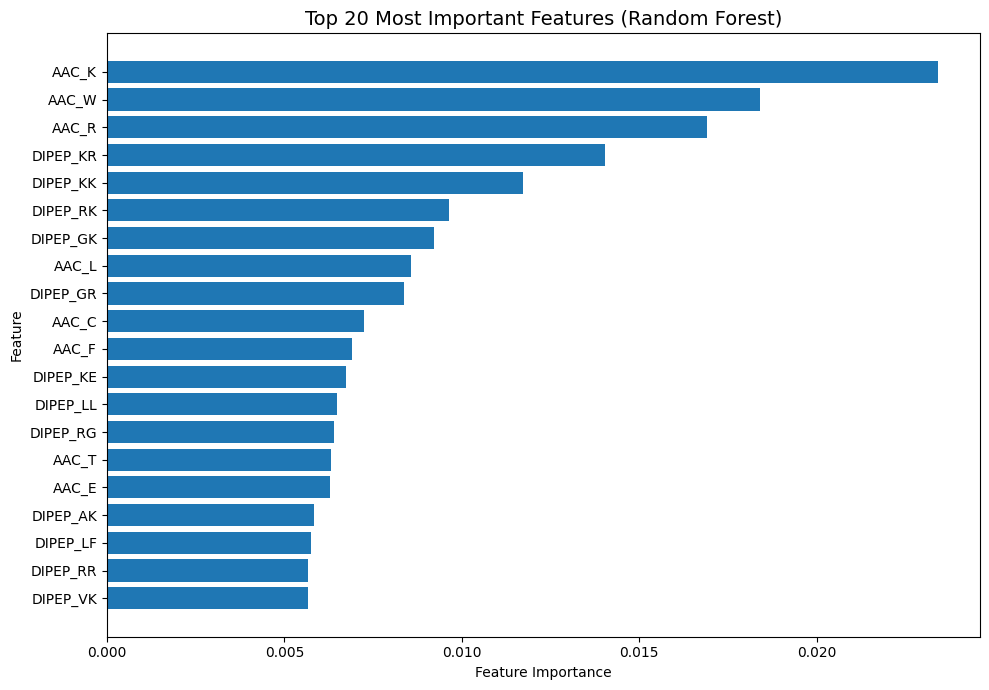

In [12]:
# ======================================
# Cell 11: Plot feature importances (RF)
# ======================================

top20 = imp_df.head(20)

plt.figure(figsize=(10, 7))
plt.barh(top20["feature"][::-1], top20["importance"][::-1])
plt.title("Top 20 Most Important Features (Random Forest)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [13]:
# ======================================
# Cell 12: Predict 5 random proteins (using XGBoost)
# ======================================

# Predictions for full dataset using the final model (XGBoost)
all_probs_xgb = xgb.predict_proba(X)[:, 1]
all_preds_xgb = xgb.predict(X)

results = df.copy()
results["pred_label_xgb"] = all_preds_xgb
results["pred_proba_RBP_xgb"] = all_probs_xgb

sample5 = results.sample(n=5, random_state=RANDOM_STATE)

print("=== XGBoost predictions for 5 random proteins ===\n")
for _, row in sample5.iterrows():
    print(f"ID:            {row['id']}")
    print(f"True label:    {row['label']}   (1 = RBP, 0 = non-RBP)")
    print(f"Predicted:     {row['pred_label_xgb']}")
    print(f"P(RBP | seq):  {row['pred_proba_RBP_xgb']:.4f}")
    seq = row["sequence"]
    print(f"Seq (first 60 aa): {seq[:60]}{'...' if len(seq) > 60 else ''}")
    print("-" * 60)


=== XGBoost predictions for 5 random proteins ===

ID:            sp|O48398|GP42_BPSP1
True label:    0   (1 = RBP, 0 = non-RBP)
Predicted:     0
P(RBP | seq):  0.0141
Seq (first 60 aa): MRKFVTTLTASPRNKKVGNHRLEISPFVSLRRYYYFNTAICIENPVTREFAIDDSYGSLS...
------------------------------------------------------------
ID:            sp|Q6AQA5|RLMKL_DESPS
True label:    1   (1 = RBP, 0 = non-RBP)
Predicted:     1
P(RBP | seq):  0.9812
Seq (first 60 aa): MCDKKDVSPQKDQYTFLANCALGLEELIEAEIKGFSGVEVELGKGTVQWQGSLETGYRAC...
------------------------------------------------------------
ID:            sp|P64578|HIGB_ECOLI
True label:    1   (1 = RBP, 0 = non-RBP)
Predicted:     1
P(RBP | seq):  0.9828
Seq (first 60 aa): MHLITQKALKDAAEKYPQHKTELVALGNTIAKGYFKKPESLKAVFPSLDNFKYLDKHYVF...
------------------------------------------------------------
ID:            sp|Q976I5|RL40_SULTO
True label:    0   (1 = RBP, 0 = non-RBP)
Predicted:     0
P(RBP | seq):  0.0331
Seq (first 60 aa): MPLTDPVKLQIVQQRIFLKKVCRDCGALN